Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Total sentiments in train set:
Sentiment
positive    560
negative     72
neutral      67
Name: count, dtype: int64

Total sentiments in test set:
Sentiment
positive    221
neutral      41
negative     38
Name: count, dtype: int64
Time to build vocab: 0.0 mins
Time to train the model: 0.23 mins


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(




Epoch 1/1
----------


Train loss 0.5779850596392696 accuracy 0.8025751072961373
[[ 30   4   4]
 [ 21   8  12]
 [ 14   1 206]]
              precision    recall  f1-score   support

    negative       0.46      0.79      0.58        38
     neutral       0.62      0.20      0.30        41
    positive       0.93      0.93      0.93       221

    accuracy                           0.81       300
   macro avg       0.67      0.64      0.60       300
weighted avg       0.83      0.81      0.80       300



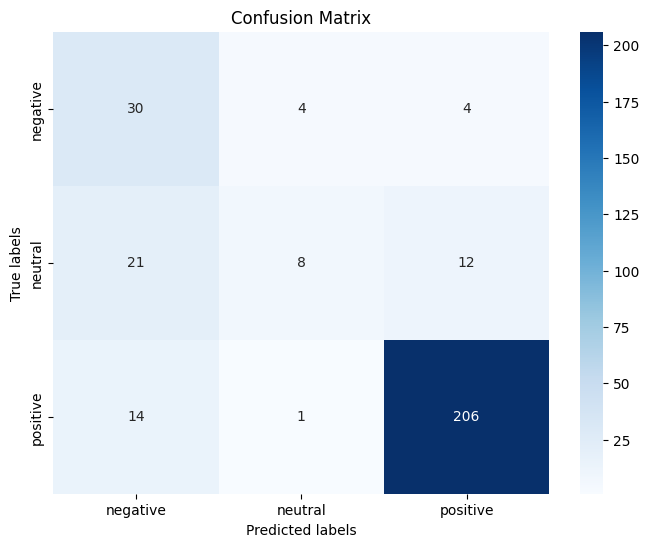

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import re
import nltk
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from time import time

# Mount Google Drive to access files
drive.mount('/content/drive')

# Load dataset
data_path = '/content/drive/My Drive/experiment/trip-advisor-copy.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
nltk.download('punkt')

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

data['Cleaned_Review'] = data['Review'].apply(clean_text)

# Adjust labels for sentiment analysis
data['Sentiment'] = pd.cut(data['Rating'], bins=[-np.inf, 2, 3, np.inf], labels=['negative', 'neutral', 'positive'], right=False)

# Split data into train and test sets (70% train, 30% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'], data['Sentiment'], test_size=0.3, random_state=42)

# Print total sentiment in train and test set
print("\nTotal sentiments in train set:")
print(train_labels.value_counts())

print("\nTotal sentiments in test set:")
print(test_labels.value_counts())

# Convert text data to TaggedDocuments for Doc2Vec
documents = [TaggedDocument(nltk.word_tokenize(text.lower()), [i]) for i, text in enumerate(data['Cleaned_Review'])]

# Train Doc2Vec model
cores = multiprocessing.cpu_count()
d2v_model = Doc2Vec(vector_size=300,
                    window=2,
                    min_count=2,
                    workers=cores-1,
                    epochs=40)

t = time()
d2v_model.build_vocab(documents)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()
d2v_model.train(documents, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

# Convert text data to Doc2Vec vectors
def text_to_vector(text):
    return d2v_model.infer_vector(nltk.word_tokenize(text.lower()), alpha=0.1, min_alpha=0.0001)

train_vectors = np.array([text_to_vector(text) for text in train_texts])
test_vectors = np.array([text_to_vector(text) for text in test_texts])

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(300, 768)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(768 * 2, n_classes)  # Combine BERT and Doc2Vec embeddings

    def forward(self, input_ids, attention_mask, doc2vec_embeddings):
        # BERT
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output

        # Doc2Vec
        doc2vec_embeddings = self.linear(doc2vec_embeddings)
        doc2vec_embeddings = self.dropout(doc2vec_embeddings)

        # Combine BERT and Doc2Vec embeddings
        combined = torch.cat((pooled_output, doc2vec_embeddings), dim=1)
        output = self.classifier(combined)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(data['Sentiment'].unique()))
model = model.to(device)

class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings):
        self.reviews = reviews
        self.ratings = ratings
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        rating = self.ratings.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=256,  # Limit the max length to reduce memory usage
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        doc2vec_vector = torch.tensor(text_to_vector(review), dtype=torch.float)

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'doc2vec_embeddings': doc2vec_vector,
            'labels': torch.tensor(0 if rating == 'negative' else 1 if rating == 'neutral' else 2, dtype=torch.long)  # Adjusted labels
        }

def create_data_loader(reviews, ratings, batch_size):
    ds = ReviewDataset(reviews, ratings)
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

BATCH_SIZE = 8  # Reduce batch size to reduce memory usage
train_data_loader = create_data_loader(train_texts, train_labels, BATCH_SIZE)
test_data_loader = create_data_loader(test_texts, test_labels, BATCH_SIZE)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

# Training loop
EPOCHS = 1  # Start with one epoch to avoid crash

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        doc2vec_embeddings = d["doc2vec_embeddings"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, doc2vec_embeddings=doc2vec_embeddings)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

print("\n")

print(f'Epoch {1}/{EPOCHS}')
print('-' * 10)

train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    None,
    len(train_texts)
)

print("\n")

print(f'Train loss {train_loss} accuracy {train_acc}')

def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            doc2vec_embeddings = d["doc2vec_embeddings"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, doc2vec_embeddings=doc2vec_embeddings)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)

    return torch.stack(predictions).cpu(), torch.stack(real_values).cpu()

y_pred, y_true = get_predictions(model, test_data_loader)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

# Visualize Confusion Matrix
labels = ['negative', 'neutral', 'positive']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
